# Supplemental Figure 7 — Co-occurrence analysis of enriched mutations in evolved phage populations.

---

Unless explicitly noted otherwise (e.g. indicated as being from Zenodo), all data used for the visualisations was generated using the Illumina or Nanopore pipeline.

Please make sure to download the input dataset `Nanopore` from the Zenodo repository and place it in a folder named `data` at root repository level.

For more information, please refer to the `README.md`.


### Figure Summary

<div style="text-indent:-2em; padding-left:2em"><strong>(A)</strong> Phage mutation Co-occurance data from the final day in each pool, using Nanopore sequencing.</div>  

## Notebook Setup
----------------------------

Run the following cell to import all required libraries, define plotting settings, and configure the environment for data analysis and visualization.

In [1]:
# --- Import necessary modules ---
import os
import sys
import json
import pickle as pkl
from importlib import reload
from pathlib import Path

notebook_dir = Path().resolve()
repo_root = notebook_dir.parent 
sys.path.append(str(repo_root))

import numpy as np
import pandas as pd
from scipy import stats
import scipy
from Bio import SeqIO
import csv
from Bio.SeqIO import QualityIO
from scripts.utils import dna_rev_comp, translate_dna2aa
from scripts.preprocessing_functions import *
from scripts.plotting import *
from scripts.Nanopore_functions import *
from scripts.Illumina_functions import *
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# ======================== PLOTTING SETTINGS ========================

# --- Custom color map for mutation visualization ---
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
], N=256)

# --- Seaborn theme configuration ---
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1
}
sns.set_theme(context="paper", style='ticks', palette="Greys_r", rc=custom_params)

# --- General matplotlib settings ---
fs = 8  # font size
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    'font.family': 'Avenir Next',
    'font.weight': 'demi', 
    'font.size': fs,
    'text.color': '#231F20',
    'axes.labelcolor': '#231F20',
    'xtick.color': '#231F20',
    'ytick.color': '#231F20',
    'axes.edgecolor': '#231F20',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'pdf.fonttype': 42,
    'text.usetex': False
})
sns.set_context("paper", rc={
    "font.size": fs,
    "axes.titlesize": fs + 1,
    "axes.labelsize": fs,
    "axes.linewidth": 1,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "legend.title_fontsize": fs + 1
})

# ======================== LAYOUT PARAMETERS ========================

# --- Pre-defined figure dimensions for multi-panel plots ---
hi = 10.5 * 0.75
wi3 = 2.24
wi2 = 4.76
wi1 = 7.24
nr = 5

# --- Utility for shortening sample names ---
short_fn = np.vectorize(lambda x: x[:5])

/Users/alicehovsepyan/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Figure S7A: Co-occurrence analysis of enriched mutations in evolved phage populations.
----------------------------

Co-occurrence of mutations in endpoint phage pools was analyzed using long-read Nanopore
sequencing. To mitigate the impact of sequencing noise, only positions with mutation enrichment
exceeding `5%` were included in the analysis, with the exception of position **R38**, which was
excluded due to systematic errors observed across all pools. Pools lacking any positions above
this threshold were omitted from the co-occurrence analysis. Within each qualifying pool, only
variants present in more than `0.5%` of total reads are displayed. Each heatmap depicts the
frequency of these genotypes alongside their constituent mutations.

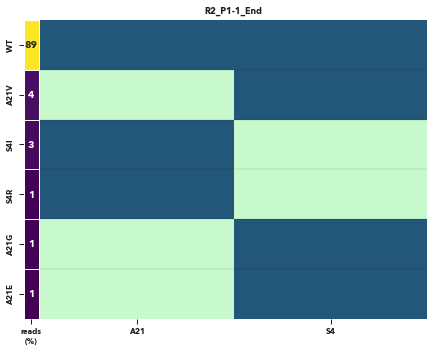

KeyboardInterrupt: 

In [ ]:
# --- Define reference sequences for analysis ---
ref_WT = "TAATGGAAACTTCCTCATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTGACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGCGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGCGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCGCTATAGCGAACTGCTGGCGATTAACCTGCTGGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCGAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCGCAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTCTTTTGGGTATTCCGTTATTATTGCGTTTCCTCGGTTTCCTTCTGGTAACTTTGTTCGGCTATCTGCTTACTTTTCTCAAAAAGGGCTTCGGTAAGATAGCTATTGCTATTTCATTGTTTCTTGCTCTTATTATTGGGCTTAACTCAATTCTTGTGGGTTATCTCTCTGATATTAGTGCTCAATTACCCTCTGACTTTGTTCAGGGTGTTCAGTTAATTCTCCCGTCTAATGCGCTTCCCTGTTTTTATGTTATTCTCTCTGT"[48:] # from 48 because all reads were cut to this start position during processing of the reads --> see process_Nanopore_reads.py 
ref_R5 = "TAATGGAAACTTCCTCATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTGACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGCGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCGCTATAGCGAACTGCTGGCGATTAACCTGATAGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCGAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCACAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTCTTTTGGGTATTCCGTTATTATTGCGTTTCCTCGGTTTCCTTCTGGTAACTTTGTTCGGCTATCTGCTTACTTTTCTCAAAAAGGGCTTCGGTAAGATAGCTATTGCTATTTCATTGTTTCTTGCTCTTATTATTGGGCTTAACTCAATTCTTGTGGGTTATCTCTCTGATATTAGTGCTCAATTACCCTCTGACTTTGTTCAGGGTGTTCAGTTAATTCTCCCGTCTAATGCGCTTCCCTGTTTTTATGTTATTCTCTCTGT"[48:]## R5
ref_R2 = "TAATGGAAACTTCCTCATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTGACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGCGAAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCACATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGAGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCTCTATAGCGAACTGCTGACAATTAACCTGCTGGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCTAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCTCAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTCTTTTGGGTATTCCGTTATTATTGCGTTTCCTCGGTTTCCTTCTGGTAACTTTGTTCGGCTATCTGCTTACTTTTCTCAAAAAGGGCTTCGGTAAGATAGCTATTGCTATTTCATTGTTTCTTGCTCTTATTATTGGGCTTAACTCAATTCTTGTGGGTTATCTCTCTGATATTAGTGCTCAATTACCCTCTGACTTTGTTCAGGGTGTTCAGTTAATTCTCCCGTCTAATGCGCTTCCCTGTTTTTATGTTATTCTCTCTGT"[48:] ## R2


# --- Set annotation lists for each reference ---
annots_WT = ['M0', 'S1', 'A2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'R251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']
annots_R5 = ['M0', 'S1', 'E2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'I156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'H251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']
annots_R2 = ['M0', 'S1', 'A2', 'K3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'L146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'T152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'L251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']

# --- Define regions of interest in the WT reference ---
start_arac =ref_WT.index("ttttttggagtaaggaggaaaa".upper()) + len("ttttttggagtaaggaggaaaa")## ref seq right before AraC start
end_arac = ref_WT.index("ggctaatggagattttcaacatgggct".upper()) ## ref seq right after AraC end

# --- Global parameters ---
data_folder = "Nanopore/Nanopore_P0109"
quality = 20
data_type = 'AA'
combine_muts = False # Whether to combine mutations (e.g., A1G_A2T -> A1G_A2T vs A1G_A2)

# --- Analyze all barcodes ---

for barcode in ["R2_P1-1_End", "R2_P1-2_End", "R2_P2-1_End", "R2_P2-2_End", "R2_P3-1_End", "R5_P1-1_End", "R5_P1-2_End", "R5_P2-2_End", "R5_P3-2_End"]: 
    # Select correct reference and annotation
    ref = ref_R2 if barcode in ["R2_P1-1_End", "R2_P1-2_End", "R2_P2-1_End", "R2_P2-2_End", "R2_P3-1_End"] else ref_R5
    annots = annots_R2 if barcode in ["R2_P1-1_End", "R2_P1-2_End", "R2_P2-1_End", "R2_P2-2_End", "R2_P3-1_End"] else annots_R5
    # Load cleaned reads from .csv
    with open(f"{repo_root}/data/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/cleaned_reads.csv", "r", newline="") as f:
        reader = csv.reader(f)
        all_reads = list(reader) 

    all_reads = [read[0] for read in all_reads]

    # Trim reads to the AraC region and translate
    reads_roi = [read[start_arac:end_arac] for read in all_reads]
    ref_roi = ref[start_arac:end_arac]
    all_aas = [translate_dna2aa(read) for read in reads_roi]
    ref_aa = translate_dna2aa(ref_roi) 

    # Load enrichment data
    araclov2_enr = pd.read_csv(f"{repo_root}/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
    total_enrichment = araclov2_enr.iloc[:-1,:].sum() # exclude "X" row

    # Identify enriched positions (mutation rate > 5%), excluding known systematic error at position 38
    pos =[idx for idx, mut_rate in enumerate(total_enrichment)if mut_rate > 0.05]
    pos=[pos for pos in pos if pos !=38]
    pos = list(sorted(set(pos)))
    if len(pos) == 0: 
        continue

    # Generate genotype dictionary for selected positions
    genotypes = get_genotype_dict_from_AAseqs(all_aas, ref_aa, annots, combined=combine_muts, not_masked_positions=pos)

    # Normalize, sort and filter genotypes > 0.5% frequency
    genotypes_sorted = dict(sorted(genotypes.items(), key=lambda item: item[1], reverse=True))
    sum_genotypes = sum(genotypes_sorted.values())
    genotypes_sorted = {k: v/sum_genotypes*100 for k, v in genotypes_sorted.items()}
    genotypes_sorted = {k: v for k, v in genotypes_sorted.items() if v > 0.5}

    # Create genotype presence table (binary matrix)
    genotypes_table = pd.DataFrame(columns = ["count"] + annots, index = list(genotypes_sorted.keys()), data = 0, dtype = "float")

    for variant, count in genotypes_sorted.items(): 
        genotypes_table.loc[variant, "count"] =count
        if variant != "WT":  
            for mut in variant.split("_"): 
                mut = mut if combine_muts else mut[:-1]
                genotypes_table.loc[variant, mut] = 1.0 

    # Save full genotype table to .csv
    genotypes_table.to_csv(f"{repo_root}/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/genotypes_table_combinedmuts{combine_muts}.csv")


    # Filter table to positions of interest only
    genotypes_table_filt = genotypes_table.iloc[:, 1:]
    genotypes_table_filt = genotypes_table_filt.iloc[:, pos]
    genotypes_table_filt= pd.concat(( genotypes_table["count"], genotypes_table_filt), axis = 1)

    # --- Plot genotype matrix ---
    fig, ax = plt.subplots(1,2, figsize=(wi1, hi*0.7), gridspec_kw={"width_ratios": [0.2, 5]})
    fig.subplots_adjust(wspace=0.005)

    # Plot counts (left heatmap)
    sns.heatmap(genotypes_table_filt.iloc[:, :1], ax=ax[0], cmap="viridis", cbar=False, annot=True, fmt=".0f",
                linewidths=0.5, linecolor="white", cbar_kws={"label": "Occurrences"}, yticklabels=True, xticklabels=["reads\n(%)"])

    colors = ["#22577A", "#C7F9CC" ] 
    binary_cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm([0,0.5,1], binary_cmap.N)

    # Plot mutation matrix (right heatmap)
    ax[1] = sns.heatmap(genotypes_table_filt.iloc[:,1:], cbar_kws={"label": "mutation rate"}, cmap = binary_cmap, xticklabels=True, cbar = False, yticklabels=False )
    for y in range(1, genotypes_table_filt.shape[0]): 
        ax[1].axhline(y, color="black", lw=0.1)

    plt.title(f"{barcode}")
    plt.show()
    
    # plt.savefig(f"final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/genotypes_combined_heatmap_posMin1percEnr_min0_5percOcc_combinedmuts{combine_muts}.pdf", bbox_inches = "tight")
